In [ ]:
import xarray as xr
import glob
import numpy as np
import os, re
import matplotlib.pyplot as plt
import datetime

import seaborn as sns
import pandas as pd
#make figure fontsizes big
sns.set_context('talk')

# 1. CNV File Processing

In [ ]:
#load paths and exclude station 7 (named St08), 30 (broken) and dark cast.

paths=sorted(glob.glob('/home/mathu/otc25_project/data_cnv/*.cnv'))
paths = [p for p in paths if (('L03_St08' not in p) and ('dark' not in p.lower()) and ('St30_2' not in p)) ]

In [ ]:
def read_cnv(file_path):
        # Read file, including header and found the *END* position
    with open(file_path, 'r') as f:
        lines = f.readlines()
    #read lines until *END* (this is the cnv file header*
    for i, ln in enumerate(lines):
        if ln.strip().startswith('*END*'):
            skiprows = i + 1
            break
    else:
        raise RuntimeError(f"*END*' not found. File {file_path} broken?") 
    #extract header
    header = lines[:skiprows]
    
    # --- colum names + simple units '# name i = ...' ---
    nice_names, units = [], []
    name_re = re.compile(r"#\s*name\s+\d+\s*=\s*(.+)$")
    for ln in header:
        m = name_re.match(ln)
        if not m:
            continue
        rhs = m.group(1).strip()  # z.B. "prdM: Pressure, Strain Gauge [db]"
        # label before '['
        label = rhs.split('[', 1)[0]
        # "nicer" Name = part after ':' 
        nice = label.split(':', 1)[-1].strip()
        # if komma in name
        if ',' in nice:
            nice = nice.split(',', 1)[0].strip()
        if not nice:
            nice = label.strip()
        nice_names.append(nice)
    
        # units in [...] 
        u = ''
        if '[' in rhs and ']' in rhs:
            u = rhs.split('[', 1)[1].split(']', 1)[0].strip()
            if ',' in u:
                u = u.split(',')[-1].strip()
        units.append(u)
    
    # --- Metadata
    def pick_after_eq(key):
        for ln in header:
            if key in ln:
                if '=' in ln:
                    return ln.split('=', 1)[1].split('[')[0].strip()
                elif ':' in ln:
                    return ln.split(':', 1)[1].strip()
        return None
    
    time_str = (pick_after_eq('NMEA UTC (Time)') or
                pick_after_eq('System UTC') or
                pick_after_eq('# start_time'))
    dt = datetime.datetime.strptime(time_str, "%b %d %Y %H:%M:%S")
    
    # --- Lat/Lon: "DD MM.mm H" -> decimal degree
    def dm_to_deg(s):
        # e.g. "69 55.27 N"
        if not s:
            return np.nan
        parts = s.split()
        if len(parts) < 3:
            return np.nan
        deg = int(parts[0])
        minutes = float(parts[1].replace(',', '.'))  # if komma
        hemi = parts[2].upper()
        val = deg + minutes/60.0
        return -val if hemi in ('S','W') else val
    
    lat = dm_to_deg(pick_after_eq('NMEA Latitude'))
    lon = dm_to_deg(pick_after_eq('NMEA Longitude'))
    station = pick_after_eq('Station')

    # read in data
    data = np.loadtxt(file_path, skiprows=skiprows)

    if len(data)==0:
        print(f"File {file_path} is empty")
        return None
    
    if data.ndim == 1:
        data = data[None, :]
    
    # build dataset, first column as coordinate
    coord_name = nice_names[0].lower().replace(' ', '_')  # z.B. 'pressure'
    coords = {coord_name: (coord_name, data[:, 0])}
    
    data_vars = {
        n.lower().replace(' ', '_'): (coord_name, data[:, j], {'units': units[j]})
        for j, n in enumerate(nice_names[1:], start=1)  #start at index 1 to exclude the coordinate
    }
    
    ds = xr.Dataset(data_vars=data_vars, coords=coords)
    
    # add coordinates and attributes
    #add nanosecond precision to suprres warning
    ds = ds.assign_coords(time=np.datetime64(dt,'ns'),lon=lon,lat=lat,station=station)
    ds.attrs.update({'source_file': os.path.basename(file_path)})

    #rename pressure to depth
    ds=ds.rename({'pressure':'depth','par/logarithmic':'par'})
    
    return ds

In [ ]:
from collections import defaultdict

#datastructure: dictionary with one key for each station. List of Datasets.


datasets={}

for path in paths:
    ds=read_cnv(path)
    if ds is not None:
        station=ds.station.values.item()
        if station in datasets.keys():
            #if type(datasets[station])==list:
            datasets[station].append(ds)
        else:
            datasets[station]=[ds]
    
#fix broken station names
merged = defaultdict(list)
for k, v in datasets.items():
    merged[k.split('_')[0].split('-')[0].zfill(2)].extend(v)

datasets=merged;del merged

# Compute and subtract Dark Count

* That cast was taken on ship deck (this is the reason why the pressure/depth is negative and constant at -0.4)
* **The median dark values is -0.0356. We subtract this value from all fluorescence values**

In [ ]:
dark=read_cnv('/home/mathu/otc25_project/data_cnv/L05_St30_testDark_02062025.cnv')

In [ ]:
plt.hist(dark['fluorescence'])
plt.show()
plt.plot(dark['fluorescence'].values)
plt.show()

print('Median',np.median(dark['fluorescence']))
print('Mean',np.mean(dark['fluorescence']).values.item())
print('Max',np.max(dark['fluorescence']).values.item())
print('Min',np.min(dark['fluorescence']).values.item())

In [ ]:
for k, v in datasets.items():
    li=[]
    for vv in v:
        #fluorescence dark corrected
        vv['fluorescence_dc']=vv['fluorescence']-(-0.0356)
        vv['fluorescence_dc'].attrs.update({'unit':'mg/m³'})
        li.append(vv)
    datasets[k]=li

# Smoothing of profiles

BGC-ARGO manual (Schmechtig 2023, https://archimer.ifremer.fr/doc/00243/35385/) mentions that spikes in Fluorescence can bias.


# NPQ corrections

Following Xing 2018: Improved correction for non-photochemical quenching of insituchlorophyll fluorescence based on a synchronous irradiance profile
(https://opg.optica.org/oe/fulltext.cfm?uri=oe-26-19-24734)

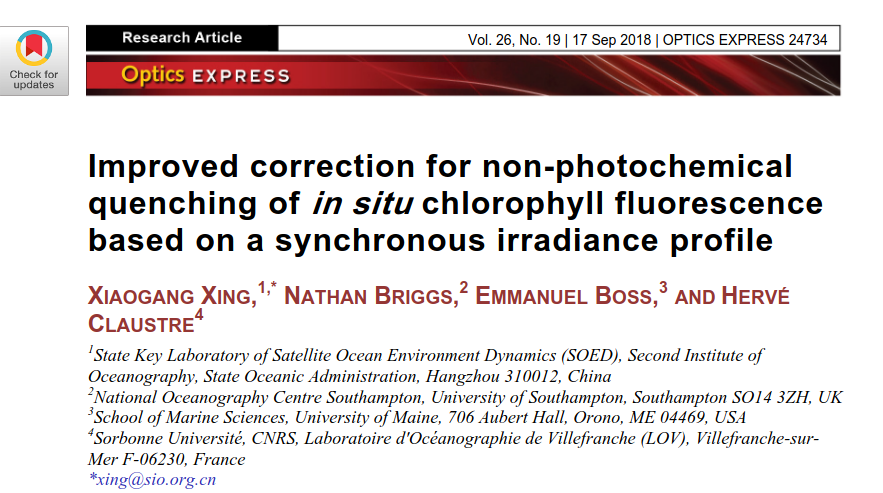

**Basic principle** Extrapolating fluorescence to surface where it is supressed due to non-photochemical quenching

**Xing method:**
* based on MLD and maximum fluorescence in MLD. 

**Sackman method:**
* based on ration of fluorescence to bbp700. (and its maximum in the mixed layer)
* as we don't measure directly bbp700, we get it from Turbidity (from Boss 2009, Figure 4: https://misclab.umeoce.maine.edu/documents/Bossetal2009_LOM.pdf)

**Plus methods**
* Idea: Use Euphotic layer depth $z_{eu}$ instead of MLD (depth where PAR reaches 1% of surface value). However they found that is better to use a light threshold of 15 μmol quanta  m−2 s−1 (this also seems safer because we would need to extrapolate PAR to the surface as its not directly measured)
* Use this where light-threshold is is larger than MLD

**Recomendation:**
* Given, that we don't measure bbp700 directly, and that our PAR measurements do not look particularly reliable, I would stick to using the simplest method (xing 2012: fluorescence_xing)

In [ ]:
def get_mld(density,crit=0.03,depth=10):
    """
    The mixed layer depth (MLD) is determined as the depth where the density is higher than  its value at 10 m by 0.03 kg m−3.
    C. de Boyer Montégut, G. Madec, A. S. Fischer, A. Lazar, and D. Iudicone, “Mixed layer depth over the global ocean: An examination of profile data and a profile-based climatology,” J. Geophys. Res. 109(C12), C12003 (2004).
    """
    sigma_limit=density.sel(depth=depth,method='nearest').values.item()+crit
    argmin=np.argmin(np.abs(density.values-sigma_limit))
    dens_limit=density.isel(depth=argmin).values.item()
    z_mld=density['depth'][argmin].values.item()
    return z_mld
    
def sackman_npq(fluo,bbp,mld):

    fluo=fluo.copy(deep=True)
    depths=fluo['depth'][fluo['depth'].values<mld]
    #limit data to mld
    fluo_=fluo.sel(depth=depths.values)
    bbp_=bbp.sel(depth=depths.values)
    #comput fluo-bbp ratio and get max
    ratio=fluo_/bbp_
    maxi_arg=np.argmax(ratio.values).item()
    maxi=ratio[maxi_arg]
    maxi_dep=depths[maxi_arg].values.item()
    #apply corrections
    fluos=fluo.values
    fluos[fluo['depth'].values<=maxi_dep]=maxi.values.item()*bbp[fluo['depth'].values<=maxi_dep]
    fluo.data=fluos        
    return fluo

def xing_npq(fluo,mld):
    fluo=fluo.copy(deep=True)
    
    depths=fluo['depth'][fluo['depth'].values<mld]
    #limit data to mld
    fluo_=fluo.sel(depth=depths.values)
    #comput fluo-bbp ratio and get max

    #import pdb 
    #pdb.set_trace()
    
    maxi_arg=np.argmax(fluo_.values).item()
    maxi=fluo_[maxi_arg]
    maxi_dep=depths[maxi_arg].values.item()
    #apply corrections
    fluos=fluo.values
    fluos[fluo['depth'].values<=maxi_dep]=maxi.values.item()
    fluo.data=fluos
    return fluo

    
def sackman_npq_plus(fluo,bbp,mld,par):
    fluo=fluo.copy(deep=True)
    #compare ipar15 and mld
    par_arg=np.argmin(np.abs(par.values-15))
    depth_par=fluo['depth'][par_arg].values.item()
    limit=np.min([depth_par,mld])
    #limit data to mld/ipar limit
    depths=fluo['depth'][fluo['depth'].values<limit]
    #limit data to mld
    fluo_=fluo.sel(depth=depths.values)
    bbp_=bbp.sel(depth=depths.values)
    #comput fluo-bbp ratio and get max
    ratio=fluo_/bbp_
    maxi_arg=np.argmax(ratio.values).item()
    maxi=ratio[maxi_arg]
    maxi_dep=depths[maxi_arg].values.item()
    #apply corrections
    fluos=fluo.values
    fluos[fluo['depth'].values<=maxi_dep]=maxi.values.item()*bbp[fluo['depth'].values<=maxi_dep]
    fluo.data=fluos     
    return fluo

def xing_npq_plus(fluo,mld,par):
    fluo=fluo.copy(deep=True)
    #compare ipar15 and mld
    par_arg=np.argmin(np.abs(par.values-15))
    depth_par=fluo['depth'][par_arg].values.item()
    limit=np.min([depth_par,mld])
    #limit data to mld/ipar limit
    depths=fluo['depth'][fluo['depth'].values<limit]
    #limit data to mld
    fluo_=fluo.sel(depth=depths.values)
    #comput fluo-bbp ratio and get max
    maxi_arg=np.argmax(fluo_.values).item()
    maxi=fluo_[maxi_arg]
    maxi_dep=depths[maxi_arg].values.item()
    #apply corrections
    fluos=fluo.values
    fluos[fluo['depth'].values<=maxi_dep]=maxi.values.item()
    fluo.data=fluos
    return fluo

In [ ]:
for k, v in datasets.items():
    li=[]
    for vv in v:
        #fluorescence dark corrected
        fluo=vv['fluorescence_dc']
        mld=get_mld(vv['density'])
        bbp700=vv['turbidity']*0.0163
        par=vv['par']
        vv['fluorescence_xing']=xing_npq(fluo,mld)
        vv['fluorescence_xing_plus']=xing_npq_plus(fluo,mld,par)
        vv['fluorescence_sackman']=sackman_npq(fluo,bbp700,mld)
        vv['fluorescence_sackman_plus']=sackman_npq_plus(fluo,bbp700,mld,par)
        
        for method in ['xing','sackman','xing_plus','sackman_plus']:
            vv[f'fluorescence_{method}'].attrs.update({'unit':'mg/m³'})

        vv.attrs.update({'MLD':mld})
        par_arg=np.argmin(np.abs(par-15).values)
        ipar15=vv['depth'][par_arg].values.item()
        vv.attrs.update({'iPAR15':ipar15})
        li.append(vv)
    datasets[k]=li

In [ ]:
output_folder='/home/mathu/otc25_project/data_nc'

for k,v in datasets.items():
    for i,vv in enumerate(v):
        savepath=os.path.join(output_folder,f"CTD_ST{k}_CAST{i+1}.nc")
        vv.to_netcdf(savepath)

# Visualize

* Density, Fluo (different corrections), Turbidity and PAR Profiles for each cast
* Fluorescence (corrected) all in one plot

In [ ]:
paths=sorted(glob.glob('/home/mathu/otc25_project/data_nc/*.nc'))
variables=['density','fluorescence','turbidity','par']
units=['kg/m³','mg/m³','NTU','µmolPho/m²/s']

In [ ]:

fig,axs=plt.subplots(len(paths),4,figsize=(15,8*len(paths)),sharey=False)

for j,p in enumerate(paths):
    ds=xr.open_dataset(p)
    #restrict dataset to top 100 meters
    ds=ds.sel(depth=slice(0,100))
    
    #get station name and cast from filepath
    idx=p.find('_ST')
    st=p[idx+3:idx+5]
    idx=p.find('CAST')
    cast=p[idx+4:idx+5]
    mld=ds.attrs['MLD'].item()
    ipar=ds.attrs['iPAR15']
    for i,v in enumerate(variables):
        ax=axs[j][i]


        if v=='fluorescence':
            ax.plot(ds[v],ds.depth,label='raw')
            ax.plot(ds['fluorescence_xing'],ds.depth,label='Xing',color='tab:orange')
            ax.plot(ds['fluorescence_xing_plus'],ds.depth,label='Xing+',color='tab:orange',ls='--')
            ax.plot(ds['fluorescence_sackman'],ds.depth,label='Sackman',color='tab:green')
            ax.plot(ds['fluorescence_sackman_plus'],ds.depth,label='Sackman+',color='tab:green',ls='--')
            ax.legend(ncols=1,loc='lower right')
        else:
            ax.plot(ds[v],ds.depth)
        
        if i==0:
            ax.set_ylabel('Depth [m]')
        else:
            ax.set_yticklabels([])
        if v=='par':
            ax.set_title(f"{v.upper()} \n [{units[i]}]")
        else:
            ax.set_title(f"{v.capitalize()} \n [{units[i]}]")
        

        if mld<100:
            ax.axhline(mld,color='black',label='MLD')
        if ipar<100:
            ax.axhline(ipar,ls='--',color='black',label='iPAR15')
        ax.invert_yaxis()

    axs[j][-1].legend()

    axs[j][0].text(-1,0.5,f"Station {st} \n Cast {cast}",transform=axs[j][0].transAxes)

In [ ]:
ylim=120

# Group paths by station
stations = defaultdict(list)
for p in paths:
    idx = p.find('_ST')
    st = p[idx+3:idx+5]
    stations[st].append(p)

# Sort stations and casts for consistent ordering
stations = dict(sorted(stations.items()))
for st in stations:
    stations[st].sort()

# Calculate subplot grid
n_stations = len(stations)
n_cols = 5
n_rows = (n_stations + n_cols - 1) // n_cols  # Ceiling division

fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows), sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Use small positive value
axs = axs.flatten() if n_rows > 1 else [axs] if n_cols == 1 else axs

# Color cycle for different casts
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i, (st, station_paths) in enumerate(stations.items()):
    ax = axs[i]
    
    for j, p in enumerate(station_paths):
        ds = xr.open_dataset(p)
        # Restrict dataset to top 100 meters
        ds = ds.sel(depth=slice(0, ylim))
        
        # Get cast number from filepath
        idx = p.find('CAST')
        cast_num = p[idx+4:idx+5]
        
        mld = ds.attrs['MLD'].item()
        ipar = ds.attrs['iPAR15']
        
        # Plot chlorophyll Xing profiles
        color = colors[j % len(colors)]
        ax.plot(ds['fluorescence_xing'], ds.depth, 
                color=color, label=f'Cast {cast_num}', linewidth=1.5)
        
        # Plot MLD and iPAR lines
        if mld < ylim:
            ax.axhline(mld, color='black', linestyle='-', alpha=0.4)
        if ipar < ylim:
            ax.axhline(ipar, color='black', linestyle='--', alpha=0.4)
    

    ax.set_title(f'Station {st}')
    #ax.set_xlabel('Chlorophyll')
    ax.set_xlabel('')
    if i % n_cols == 0:  # Only show ylabel for first column
        ax.set_ylabel('Depth [m]')

    ax.set_xlim([0,None])

    
    # Set consistent x limits if needed
    # ax.set_xlim(0, max_chlorophyll_value)

# Hide unused subplots
for i in range(len(stations), len(axs)):
    axs[i].set_visible(False)

# Create separate legend for casts and lines outside the plot area
handles_cast, labels_cast = [], []
handles_lines, labels_lines = [], []

# Sample handles for casts (using 10th subplot)
if len(stations) > 0:
    first_ax = axs[10]
    handles_cast, labels_cast = first_ax.get_legend_handles_labels()

# Create handles for MLD and iPAR lines
from matplotlib.lines import Line2D
handles_lines.extend([
    Line2D([0], [0], color='black', linestyle='-', label='MLD',alpha=0.5),
    Line2D([0], [0], color='black', linestyle='--', label='iPAR15',alpha=0.5)
])

# Create legends outside the plot
#fig.tight_layout()

# Legend for casts (top right outside)
if handles_cast:
    fig.legend(handles_cast, labels_cast, 
               title='Casts',
               loc='upper right', 
               bbox_to_anchor=(1.03, 0.8),
               frameon=True)

# Legend for lines (top left outside)
if handles_lines:
    fig.legend(handles_lines, ['MLD', 'iPAR15'], 
               title='Lines',
               loc='upper right', 
               bbox_to_anchor=(1.03, 0.9),
               frameon=True)
for ax in axs.flatten():
    ax.invert_yaxis()

#plt.subplots_adjust(top=0.9)  # Make room for legends
fig.suptitle('Fluorescence [mg/m³] - Xing correction',y=0.92)
plt.show()